In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

model_name = '20220910_beta_h48'

In [2]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2020-12-07 18:00:00+00:00,ADAUSDT,0.15505,0.15527,0.15150,0.15238,33646821.0,5.147920e+06,15008.0,12238819.0,...,0.153511,0.153424,0.001023,0.000273,0.153694,0.153333,0.000139,-0.000222,0.002357,0.000009
1,2020-12-15 04:00:00+00:00,ADAUSDT,0.15910,0.15920,0.15448,0.15520,32470335.0,5.093913e+06,12463.0,10275365.0,...,0.157899,0.157761,0.000935,0.000230,0.158054,0.157774,0.000086,-0.000194,0.001777,0.000007
2,2020-12-21 12:00:00+00:00,ADAUSDT,0.15115,0.15134,0.14700,0.14973,61560480.0,9.172317e+06,33818.0,26333429.0,...,0.149167,0.149159,0.000651,0.000334,0.149463,0.148852,0.000277,-0.000335,0.004102,0.000020
3,2020-12-20 11:00:00+00:00,ADAUSDT,0.16452,0.16543,0.16431,0.16487,7819718.0,1.289467e+06,5119.0,4170453.0,...,0.164865,0.164834,0.000240,0.000150,0.164955,0.164756,0.000092,-0.000107,0.001209,0.000002
4,2020-12-13 17:00:00+00:00,ADAUSDT,0.15593,0.15616,0.15470,0.15511,10769020.0,1.673411e+06,7303.0,4760521.0,...,0.155362,0.155347,0.000296,0.000148,0.155478,0.155255,0.000098,-0.000126,0.001438,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241375,2021-06-22 00:00:00+00:00,MATICUSDT,1.09670,1.10670,1.02220,1.09330,111988162.0,1.191537e+08,192167.0,55487505.0,...,1.066723,1.064258,0.017558,0.006363,1.071565,1.061947,0.004768,-0.004850,0.009033,0.000094
241376,2021-06-27 12:00:00+00:00,MATICUSDT,1.06770,1.08170,1.06270,1.07280,20027021.0,2.147299e+07,32544.0,9758486.0,...,1.071557,1.072067,0.003921,0.001332,1.072720,1.070467,0.001225,-0.001028,0.002103,0.000005
241377,2021-06-28 11:00:00+00:00,MATICUSDT,1.10260,1.10840,1.09220,1.10070,20436788.0,2.246666e+07,28574.0,9940371.0,...,1.099060,1.098933,0.002781,0.001431,1.100322,1.098090,0.001210,-0.001022,0.002030,0.000005
241378,2021-06-21 02:00:00+00:00,MATICUSDT,1.36590,1.37450,1.34360,1.36340,33374891.0,4.533041e+07,53153.0,16444852.0,...,1.360682,1.360333,0.008911,0.002735,1.362653,1.358787,0.001942,-0.001925,0.002844,0.000009


op          hi         lo  \
timestamp                 symbol                                      
2013-10-06 21:00:00+00:00 BTC      122.00000   122.00000   122.0000   
2013-10-07 20:00:00+00:00 BTC      123.61000   123.61000   123.6100   
2013-10-08 02:00:00+00:00 BTC      123.91000   123.91000   123.9000   
2013-10-08 05:00:00+00:00 BTC      124.19000   124.19000   124.1800   
2013-10-09 09:00:00+00:00 BTC      124.01687   124.01687   123.8400   
...                                      ...         ...        ...   
2022-11-21 02:00:00+00:00 ETH     1130.83000  1132.68000  1110.0800   
                          LINK       5.74600     5.75800     5.5930   
                          LTC       63.05000    63.43000    61.8700   
                          MATIC      0.79120     0.79210     0.7747   
                          XRP        0.35430     0.35630     0.3476   

                                         cl        volume      twap_5m  \
timestamp                 symbol                                         
2013-10-06 21:00:00+00:00 BTC      122.0000  1.000000e-01   122.000000   
2013-10-07 20:00:00+00:00 BTC      123.6100  1.000000e-01   123.610000   
2013-10-08 02:00:00+00:00 BTC      123.9000  1.991600e+00   123.900000   
2013-10-08 05:00:00+00:00 BTC      124.1800  2.000000e+00   124.180000   
2013-10-09 09:00:00+00:00 BTC      123.8400  2.823000e+00   123.840000   
...                                     ...           ...          ...   
2022-11-21 02:00:00+00:00 ETH     1122.2300  6.361281e+05  1120.324167   
                          LINK       5.6840  3.672967e+06     5.660833   
                          LTC       63.0400  8.316811e+05    62.815833   
                          MATIC      0.7839  6.229565e+07     0.781800   
                          XRP        0.3487  1.650089e+08     0.351083   

                                  extended  
timestamp                 symbol            
2013-10-06 21:00:00+00:00 BTC         True  
2013-10-07 20:00:00+00:00 BTC         True  
2013-10-08 02:00:00+00:00 BTC         True  
2013-10-08 05:00:00+00:00 BTC         True  
2013-10-09 09:00:00+00:00 BTC         True  
...                                    ...  
2022-11-21 02:00:00+00:00 ETH        False  
                          LINK       False  
                          LTC        False  
                          MATIC      False  
                          XRP        False  

[420715 rows x 7 columns]

In [3]:
# based on 20220910_eda

import numba

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

def calc_features(df):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    
    df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    df['beta'] = (
        (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
        / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    ).fillna(0).clip(0.1, 2.0)
    
    # ret_mean = df.groupby('timestamp')['ret'].transform('mean')
    dfs = [
        df,
        # (unbiased_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
        # (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
    ]
    for col in get_feature_columns(df):
        # df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        # df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        feature_mean = df.groupby('timestamp')[col].transform('mean')
        dfs += [
            (2 * unbiased_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    for t in [12, 24, 36, 48, 72]:
    # for t in [2, 4, 8, 12, 24, 36, 48, 72]:
        feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
        feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
        feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

        feature_stoch_k, feature_stoch_d = stoch(t)
        feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
        feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

        feature_stochf_k, feature_stochf_d = stochf(t)
        feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
        feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

        feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
        feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
        feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

        feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))
        
        ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

        dfs += [
            adx(t).rename('feature_adx_{}'.format(t)),
            adxr(t).rename('feature_adxr_{}'.format(t)),
            feature_rsi,
            rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
            rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
            aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
            aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
            aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
            # cci(t).rename('feature_cci_{}'.format(t)),
            # cmo(t).rename('feature_cmo_{}'.format(t)),
            dx(t).rename('feature_dx_{}'.format(t)),
            mfi(t).rename('feature_mfi_{}'.format(t)),
            # trix(t).rename('feature_trix_{}'.format(t)),
            # feature_integ_std,
            # feature_std,
            # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
            # feature_mom,
            # atr(t).rename('feature_atr_{}'.format(t)),
            # natr(t).rename('feature_natr_{}'.format(t)),
            range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
            # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
            # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
            # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
            # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
            # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
            # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
            # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
            volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
            range_pos(t).rename('feature_range_pos_{}'.format(t)),
            range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
            # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
            obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
            ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
            # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
            # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
            feature_stoch_k,
            feature_stoch_d,
            (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
            (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
            feature_stochf_k,
            feature_stochf_d,
            (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
            (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
            feature_stochrsi_k,
            feature_stochrsi_d,
            (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
            (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
            ultosc(t).rename('feature_ultosc_{}'.format(t)),
            volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
            skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
            # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
            (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
            feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
            (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
            # dimension less but not bounded
            # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
            # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
            # zscore(t).rename('feature_zscore_{}'.format(t)),
            # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
            # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
            # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
            # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
        ]

    return pd.concat(dfs, axis=1)

In [4]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        self._model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        self._model = BaggingRegressor(self._model, random_state=1)
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.horizon = 48
        self.provider_configs = provider_configs
        self.merge_data = merge_data

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        print('fit df.shape', df.shape)
        
        # return self._model.fit(df[features], df['ret_beta'])
        return self._model.fit(df[features], np.sign(df['ret_beta']), sample_weight=np.abs(df['ret_beta']))
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position'] -= df.groupby('timestamp')['position_beta'].transform('mean')
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df
    


/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2370422519.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = (
/tmp/ipykernel_12/433172223.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

fit df.shape (396902, 529)


/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2370422519.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = (
/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

fit df.shape (363608, 529)


/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2370422519.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = (
/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

fit df.shape (339309, 529)


/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2370422519.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = (
/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

fit df.shape (299906, 529)


/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2370422519.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = (
/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

fit df.shape (280833, 529)


/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2370422519.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = (


return without cost statistics
mean 0.00443683691727293
std 0.038027280588197
sharpe 0.1166751039949474
double sharpe 0.8151905856906566
max drawdown 38.23189829009748
min -1.911781811616638
min sharpe 0.0023207862373798077
return with cost statistics
mean 0.0035663127735024915
std 0.038029122731913334
sharpe 0.09377846548402517
double sharpe 0.6055076870014849
max drawdown 39.54918252585036
min -1.9127818116166382
min sharpe 0.0018644639717105673


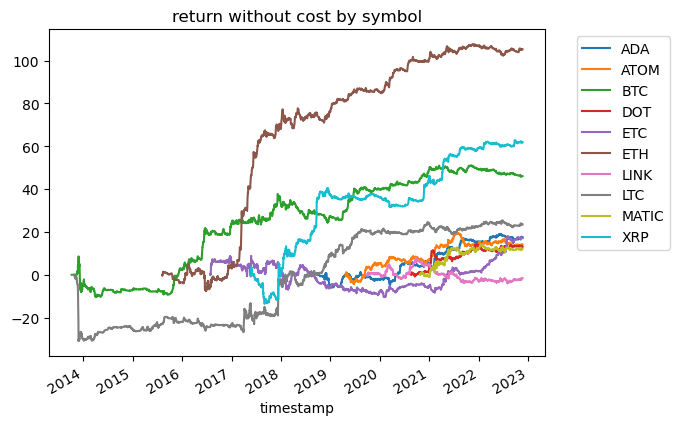

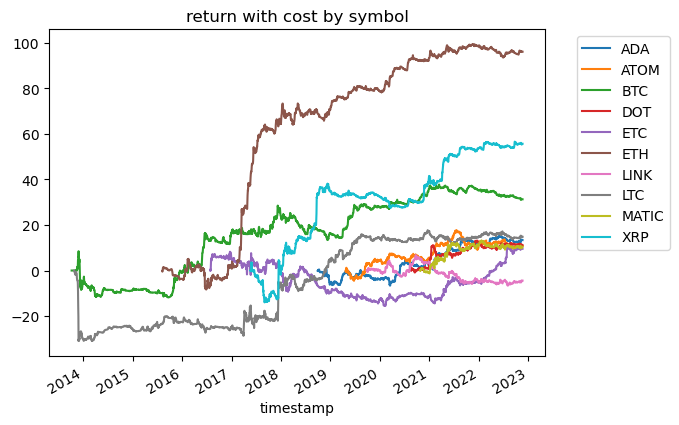

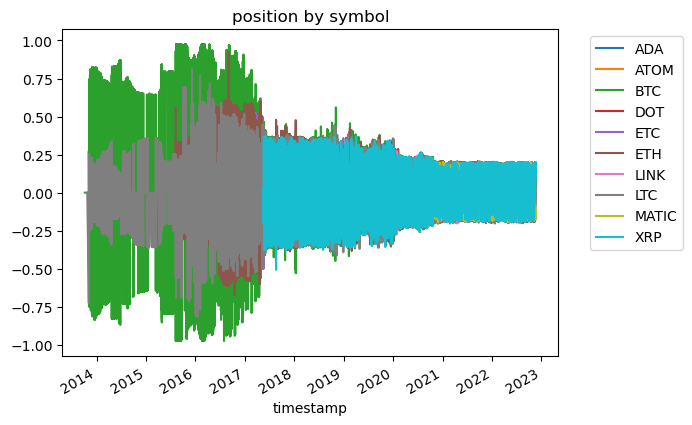

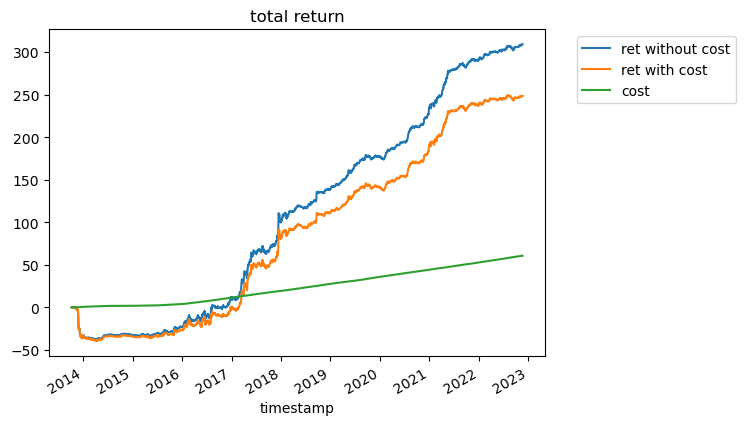

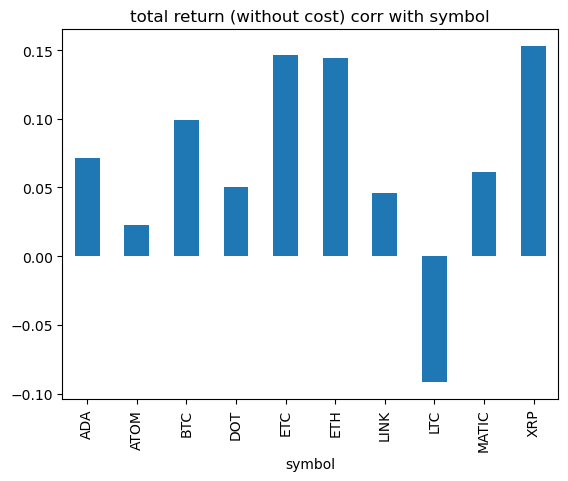

return without cost statistics
mean 0.004717099935762758
std 0.021664025581085915
sharpe 0.21773884627800147
double sharpe 0.8972563803661622
max drawdown 5.340495829668285
min -0.12117929111131019
min sharpe 0.03892661767949961
return with cost statistics
mean 0.003828027977716939
std 0.02165796146899029
sharpe 0.1767492283702638
double sharpe 0.6510646514108056
max drawdown 6.414798969675488
min -0.12262033926898162
min sharpe 0.0312185400932526


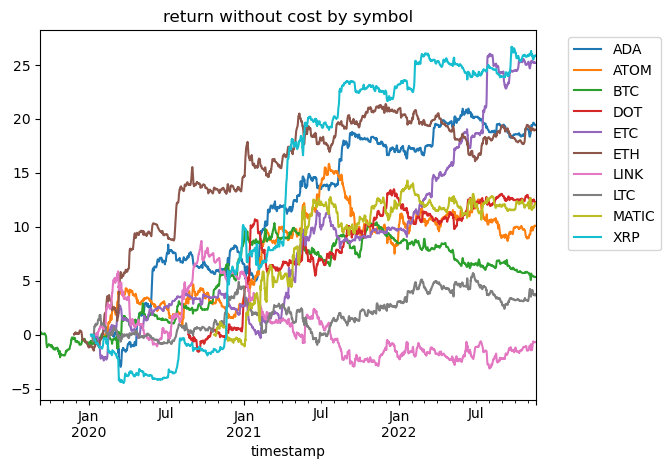

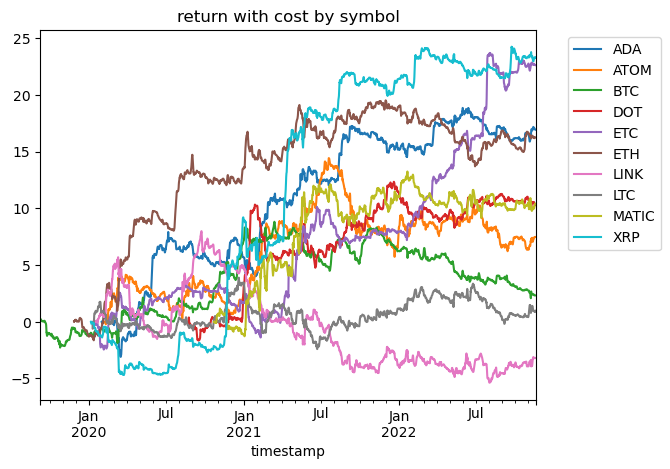

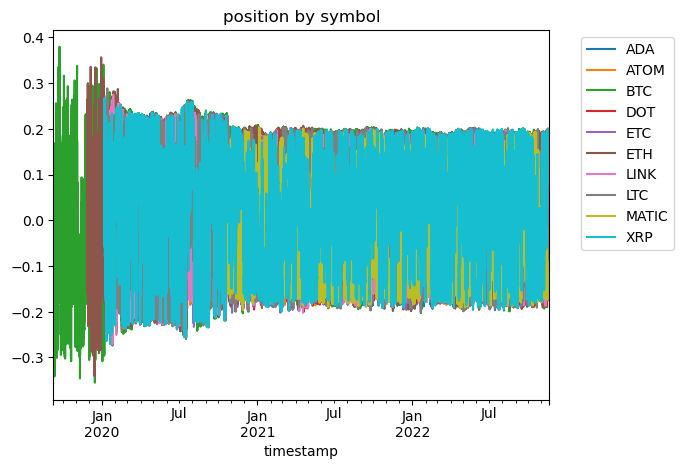

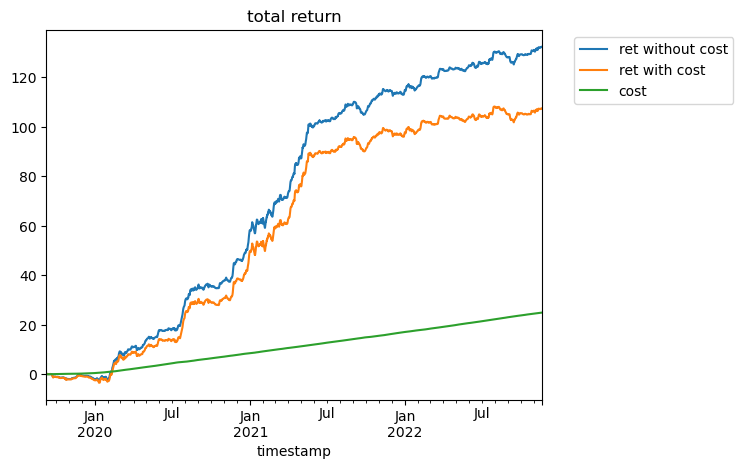

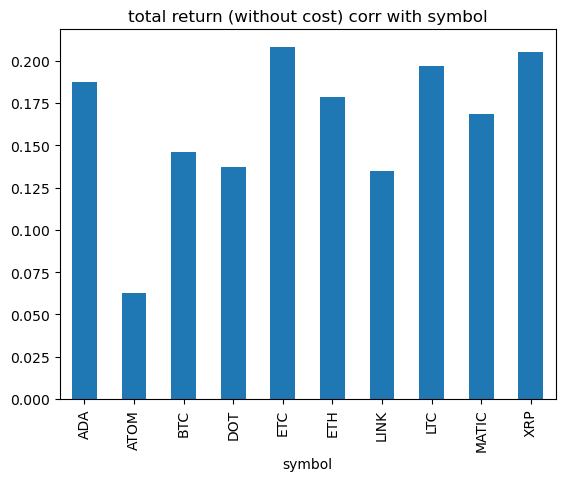

/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2370422519.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = (
/tmp/ipykernel_12/433172223.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

fit df.shape (420443, 529)


In [5]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-20 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]

df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-48 - 1) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank()

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
visualize_result(df_cv.loc[~df['extended']].dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)

expt

- [20220910_beta_h48/20221121_111321.ipynb](20220910_beta_h48/20221121_111321.ipynb) full -SOL,BNB+LTC,ETC

/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2370422519.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = (


timestamp                  symbol
2022-09-22 02:00:00+00:00  ADA      -0.140000
                           ATOM      0.180000
                           BTC       0.020000
                           DOT       0.100000
                           ETC       0.060000
                                       ...   
2022-11-21 02:00:00+00:00  ETH      -0.147287
                           LINK     -0.027287
                           LTC       0.172713
                           MATIC     0.052713
                           XRP      -0.187287
Name: position, Length: 14410, dtype: float64
['ADA', 'ATOM', 'BTC', 'DOT', 'ETC', 'ETH', 'LINK', 'LTC', 'MATIC', 'XRP']
test shift predict


/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_12/2370422519.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = (
/tmp/ipykernel_12/2370422519.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

position1  position2  position3
timestamp                 symbol                                 
2022-09-22 03:00:00+00:00 ADA      0.206256   0.206256   0.180000
                          ATOM     0.127925   0.127925  -0.060000
                          BTC      0.049593   0.049593   0.060000
                          DOT     -0.146236  -0.146236   0.020000
                          ETC     -0.107070  -0.107070  -0.140000
...                                     ...        ...        ...
2022-11-21 01:00:00+00:00 ETH     -0.146854  -0.146854  -0.146854
                          LINK    -0.066854  -0.066854  -0.066854
                          LTC      0.173146   0.173146   0.173146
                          MATIC    0.053146   0.053146   0.053146
                          XRP     -0.186854  -0.186854  -0.186854

[14390 rows x 3 columns]

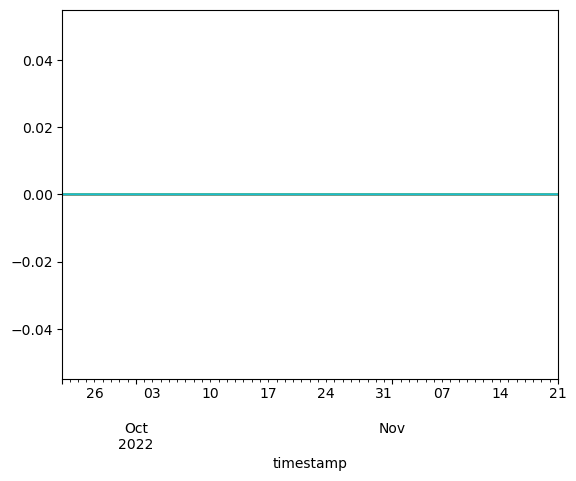

ADA (1439, 4)
ATOM (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETC (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
LTC (1439, 4)
MATIC (1439, 4)
XRP (1439, 4)


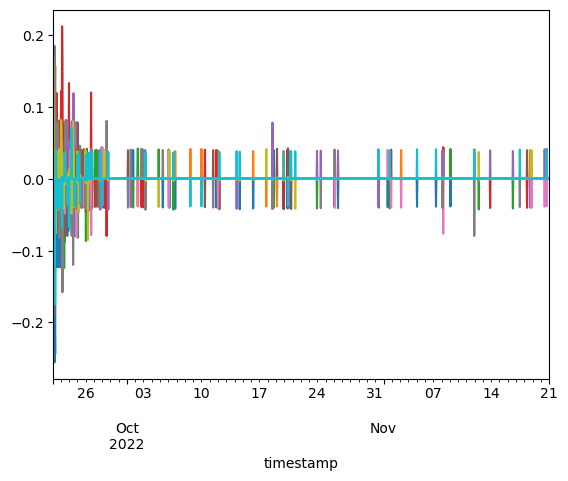

In [6]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()